In [ ]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

The below figure is the model used for the 3 class classification problem of IRIS dataset in the code below

The image was created using google draw (also available in the report given part of the assignment)

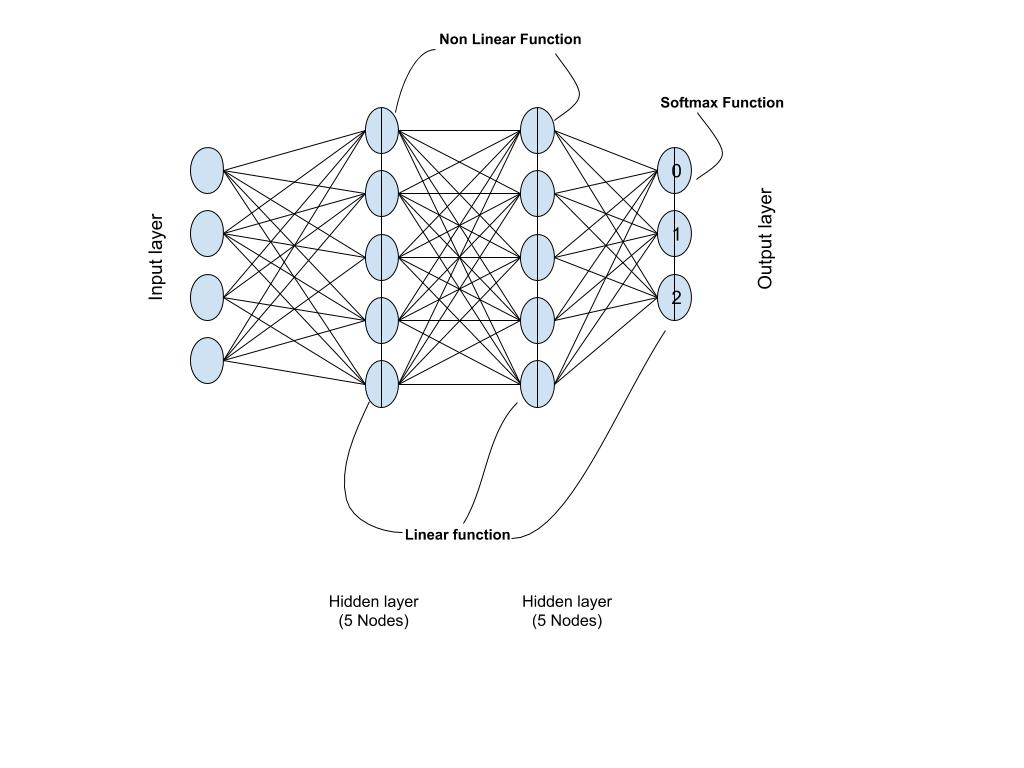

**Dataset**: IRIS Dataset


**Features**:["sepal length","sepal width","petal length","petal width"]

**Classes** : Iris Setosa, Iris Versicolour, Iris Virginica

**Model**: 3 Layer Neural Network 3 class classification

Input -> HiddenLayer1 -> HiddenLayer2 -> Output

x  ------ > a h  ------>  a h ------> a softmax

a is the preactivation function a = WX + b

h is the non linear activation function h = g(a) [g can be relu /sigmoid/ tanh]

Output layer is the softmax probabilities e^2ai/Sum(e^ai) 

***Loss function:*** Cross Entropy

***Objective*** is the minimize the Cross Entropy loss + L2 norm(w)

***Learning Algorithm:*** Gradient Descent with backpropagation




In [ ]:
def softmax(vec):
    """
        The function transform vec to corresponding probabilities [0,1] and such that sum of result = 1
    """
    value = np.exp(vec)
    return value / np.sum(value, axis = 1, keepdims = True) #sum the exponentiation of the vector

def sigmoid(vec):
    """
        The function transforms each value of vec to lie in the range[0,1]
        using logistic function from the sigmoid class of functions. This is used to introduce non linearity in the neurons
    """
    return 1.0/(1.0+np.exp(-vec))

def sigmoid_derivative(vec):
    """
        The function return the derivative of the sigmoid function
    """
    return sigmoid(vec)*(1-sigmoid(vec))

def relu(vec):
    """
        The function transforms the vec to have values [0,Inf). This is used to introduce non linearity in the neurons
    """
    return np.maximum(vec, 0)

In [ ]:
def prediction_loss(predicted_class, actual_class):
    """
        The function return how much the prediction differs from the true labels/actual class
        predicted_class has the probabilities of each class
    """
    #find the the probability corresponding to the actual class
    predicted_prob_actual_class = predicted_class[np.arange(len(predicted_class)), actual_class]
    #Summation of the log of probabilites will give the entropy of the entire training sample
    entropy = -1.0 * np.sum(np.log(predicted_prob_actual_class)) / len(actual_class)
    return entropy

def accuracy(predicted_class, actual_class):
    """
        The function returns what percentage of predicted_class is same as the actual class
    """
    predicted_class = np.argmax(predicted_class, axis=1) #find the label with maximum probability 
    total_correct_predictions = np.sum([a==b for a,b in zip(predicted_class,actual_class)]) #check how many predicted class labels is same as actual class
    accuracy = 100 * total_correct_predictions / len(actual_class)
    return accuracy

In [ ]:
def getData():
    """
    The data set has 150 feature vectors
    1-50 for class 0, 50-100 for class 1 and 100-150 class 2
    The feature vectors from 5-45,55-95,105-145, a total of 120 are used for training and the rest (30) is used for testing
    """
    datax = load_iris()['data']
    datay = load_iris()['target']
    
    training_index = [ y for x in [range(5,45),range(55,95),range(105,145)] for y in x]
    testing_index = [y for x in [range(0,5),range(45,55),range(95,105),range(145,150)] for y in x]
       
    trainx =  datax[training_index]
    trainy =  datay[training_index]
    
    testx = datax[testing_index]
    testy = datay[testing_index]
    
    print("Training samples x",len(trainx),"Training samples y",len(trainy))
    print("Testing samples x",len(testx),"Testing samples y",len(testy))
        
    return trainx,trainy,testx,testy

def oneHotEncoding(data,classes):
    """
        The target labels are converted to one hot vector, where one value will be 1 corresponding to the label
        and the rest will be 0
    """
    one_hot_vector = np.zeros((len(data),classes))
    for i,c in enumerate(data):
        one_hot_vector[i][c]=1
    return one_hot_vector

In [ ]:
def forward_pass(trainx,W1,W2,W3,b1,b2,b3):
    """
        Input: The training samples that acts as the input layer
                W1,b1 for hidden layer1
                W2,b2 for hidden layer2
                W3,b3 for output layer
        Output: Preactivation and Activation output each hidden layer and the output probabilities
        Preactivations are linear and the activation is non linear 
        Output layer is a linear operation followed by softmax
    """
    a1 = np.dot(trainx, W1) + b1
    h1 = relu(a1)

    a2 = np.dot(h1,W2)+b2
    h2 = relu(a2)
    
    output_linear = np.dot(h2, W3) + b3
    predicted = softmax(output_linear)
    
    return a1,h1,a2,h2, predicted



```
Gradient Descent Algorithm
In every epoch, there is a forward pass through the training data
find the gradient of the loss function with respect to weights, bias, hidden layers using back propagation
Update the parameters using the gradients from last step
```



In [ ]:
"""
The below function could be made compact by reducing the back propagation logic in a loop, 
but I have unrolled it for my understanding to get the hang of back propagation
"""

def gradient_descent(trainx,trainy,one_hot_vector,W1,W2,W3,b1,b2,b3,epochs=5000,eta=0.01,rlambda=0.01,step=500):

    loss_list = []
    for epch in range(epochs):
        a1,h1,a2,h2, predicted = forward_pass(trainx,W1,W2,W3,b1,b2,b3)
        
        #Using the cross entropy as the loss function
        gradient_L_wrt_y = (predicted - one_hot_vector) / predicted.shape[0]
        
        ##### start back propagation
        gradient_L_wrt_W3 = np.dot(h2.T, gradient_L_wrt_y)   #gradient wrt 3rd/final layer weights
        gradient_L_wrt_b3 = np.sum(gradient_L_wrt_y, axis = 0, keepdims = True)
        
        gradient_L_wrt_h2 = np.dot(gradient_L_wrt_y, W3.T)  #gradient wrt 2nd hidden layer's activation
        gradient_L_wrt_h2[h2 <= 0] = 0 #gradient of 2nd layer's relu only for the activated neuron

        gradient_L_wrt_W2 = np.dot(h1.T,gradient_L_wrt_h2)  #gradient wrt 2nd layer weights
        gradient_L_wrt_b2 = np.sum(gradient_L_wrt_h2, axis = 0, keepdims = True)
        
        gradient_L_wrt_h1 = np.dot(gradient_L_wrt_h2, W2.T) #gradient wrt 1st hidden layer's activation
        gradient_L_wrt_h1[h1 <= 0] = 0 #gradient of 1st layer's relu only for the activated neuron
        

        gradient_L_wrt_W1 = np.dot(trainx.T, gradient_L_wrt_h1) #gradient wrt 1st layer weights
        gradient_L_wrt_b1 = np.sum(gradient_L_wrt_h1, axis = 0, keepdims = True)
    
        #L2 Norm controlled by hyperparameter rlambda 
        gradient_L_wrt_W3 += rlambda * W3 #this is an exponential sum acts as the momentum
        gradient_L_wrt_W2 += rlambda * W2 #this is an exponential sum acts as the momentum
        gradient_L_wrt_W1 += rlambda * W1 #this is an exponential sum acts as the momentum

        ##### end back propagation

        #gradient updates to the network parameters
        W1 = W1 - eta * gradient_L_wrt_W1
        b1 = b1 - eta * gradient_L_wrt_b1
        W2 = W2 - eta * gradient_L_wrt_W2
        b2 = b2 - eta * gradient_L_wrt_b2
        W3 = W3 - eta * gradient_L_wrt_W3
        b3 = b3 - eta * gradient_L_wrt_b3
                
        if(epch % step) == 0:
            #find the loss
            loss = prediction_loss(predicted, trainy)
            print('Loss at step {0:4d}: {1}'.format(epch, loss))
            loss_list.append(loss)

    return W1,W2,W3,b1,b2,b3,loss_list

In [ ]:
def initialze_params(h1layer_nodes,h2layer_nodes,nfeatures=4,classes=3):
    W1 = np.random.normal(0, 1, [nfeatures, h1layer_nodes]) 
    b1 = np.zeros((1, h1layer_nodes))
    
    W2 = np.random.normal(0, 1, [h1layer_nodes, h2layer_nodes]) 
    b2 = np.zeros((1, h2layer_nodes))
    
    W3 = np.random.normal(0, 1, [h2layer_nodes, classes]) 
    b3 = np.zeros((1, classes))
    return W1,W2,W3,b1,b2,b3

In [ ]:
classes = 3
h1layer_nodes = 5
h2layer_nodes = 5
nfeatures = 4

trainx,trainy,testx,testy = getData()
one_hot_vector = oneHotEncoding(trainy,classes=3)

Training samples x 120 Training samples y 120
Testing samples x 30 Testing samples y 30


**Task 1**:

a) vary the learning rate and show the best learning rate value when your run it for 50 epochs.

------------------------------------------
                eta = 1e-05            
------------------------------------------
Loss at step    0: 13.9698197308387
Loss at step  500: 11.865891036351956
Loss at step 1000: 10.072758906169485
Loss at step 1500: 8.53146305411023
Loss at step 2000: 7.19568747650549
Loss at step 2500: 6.029449406892852
Loss at step 3000: 5.007361244320914
Loss at step 3500: 4.123003116517979
Loss at step 4000: 3.4112853665188205
Loss at step 4500: 2.9001222961650126
------------------------------------------
                eta = 0.0001            
------------------------------------------
Loss at step    0: 23.010910335093065
Loss at step  500: 1.3386080050887303
Loss at step 1000: 1.2395856218718548
Loss at step 1500: 1.1720755661157776
Loss at step 2000: 1.1283672444268074
Loss at step 2500: 1.0998385325551112
Loss at step 3000: 1.080221940659752
Loss at step 3500: 1.0653328489108984
Loss at step 4000: 1.0526568130992728
Loss at step 4500: 1.04102509568038

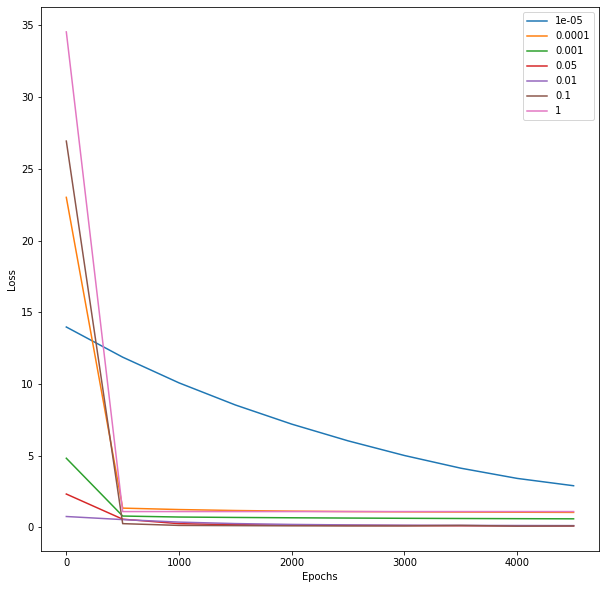

In [ ]:
learning_rates = [0.00001,0.0001,0.001,0.05,0.01,0.1,1]


fig = plt.figure(figsize=(10,10))
for eta in learning_rates:
    W1,W2,W3,b1,b2,b3 = initialze_params(h1layer_nodes = 5,h2layer_nodes = 5)
    print("------------------------------------------")
    print("                eta = {}            ".format(eta))
    print("------------------------------------------")
    W1,W2,W3,b1,b2,b3,ll = gradient_descent(trainx,trainy,one_hot_vector,W1,W2,W3,b1,b2,b3,epochs=5000,eta=eta,rlambda=0)
    plt.plot(range(0,5000,500),ll,label=eta)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Task 2**:

b) vary the number of epochs from 10 to 100 in a step of 10 and show the loss value curve (using the best learning rate obtained from (a))

------------------------------------------
                epoch 10            
------------------------------------------
Loss at step    0: 65.49250679890146
Loss at step    1: 36.08704092539895
Loss at step    2: 18.210193672863973
Loss at step    3: 14.365607545137713
Loss at step    4: 8.618454626455962
Loss at step    5: 5.31559549257521
Loss at step    6: 3.2511208288176667
Loss at step    7: 1.751263471324646
Loss at step    8: 0.7276837973495595
Loss at step    9: 0.5468335986998909
------------------------------------------
                epoch 20            
------------------------------------------
Loss at step    0: 17.517046461576843
Loss at step    2: 0.7755428152329914
Loss at step    4: 0.8168048856022578
Loss at step    6: 0.842590967798816
Loss at step    8: 0.8454535273680163
Loss at step   10: 0.8257198987089244
Loss at step   12: 0.7919987170850245
Loss at step   14: 0.7536160189326132
Loss at step   16: 0.7174386666717247
Loss at step   18: 0.6857121768607439
-

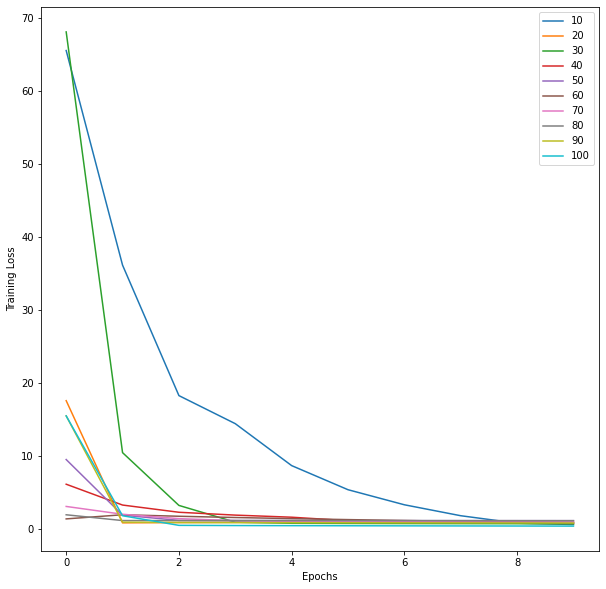

In [ ]:
best_eta = 0.01
fig = plt.figure(figsize=(10,10))
for epch in range(10,101,10):
    W1,W2,W3,b1,b2,b3 = initialze_params(h1layer_nodes = 5,h2layer_nodes = 5)
    print("------------------------------------------")
    print("                epoch {}            ".format(epch))
    print("------------------------------------------")
    W1,W2,W3,b1,b2,b3,ll = gradient_descent(trainx,trainy,one_hot_vector,W1,W2,W3,b1,b2,b3,epochs=epch,eta=best_eta,rlambda=0,step=epch/10)
    plt.plot(ll,label=epch)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

**Task 3:**

c) add L2 regularization - show the comparisons with and without this regularization and analyze your results. 

------------------------------------------
                lambda 1e-05            
------------------------------------------
Loss at step    0: 4.828891342401821
Loss at step  500: 1.0986154151918082
Loss at step 1000: 1.0986123996348554
Loss at step 1500: 1.0986122926050947
Loss at step 2000: 1.09861228880778
Loss at step 2500: 1.0986122886730645
Loss at step 3000: 1.0986122886682852
Loss at step 3500: 1.098612288668116
Loss at step 4000: 1.0986122886681102
Loss at step 4500: 1.09861228866811
------------------------------------------
                lambda 0.0001            
------------------------------------------
Loss at step    0: 2.588361627613326
Loss at step  500: 0.6339495349548201
Loss at step 1000: 0.4240276504229377
Loss at step 1500: 0.3160548607230606
Loss at step 2000: 0.24907347945421643
Loss at step 2500: 0.20523164135042649
Loss at step 3000: 0.17608902590632516
Loss at step 3500: 0.15481582660868287
Loss at step 4000: 0.1387295367613267
Loss at step 4500: 0.12624

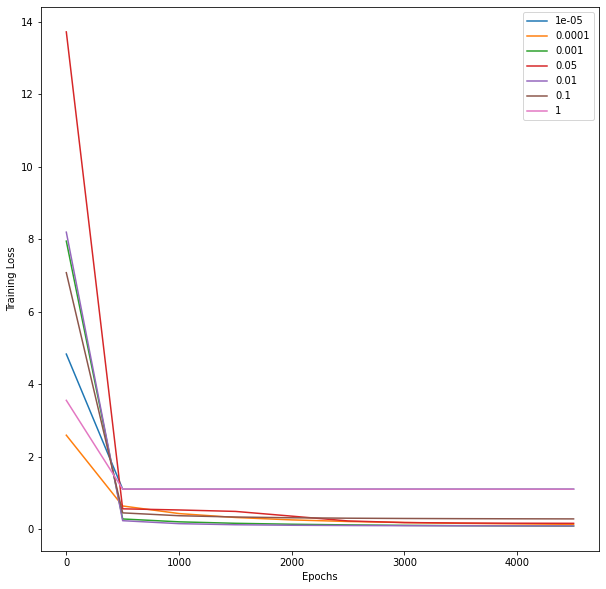

In [ ]:
best_eta = 0.01
rlambda_list =  [0.00001,0.0001,0.001,0.05,0.01,0.1,1]
fig = plt.figure(figsize=(10,10))
for r in rlambda_list:
    W1,W2,W3,b1,b2,b3 = initialze_params(h1layer_nodes = 5,h2layer_nodes = 5)
    print("------------------------------------------")
    print("                lambda {}            ".format(r))
    print("------------------------------------------")
    W1,W2,W3,b1,b2,b3,ll = gradient_descent(trainx,trainy,one_hot_vector,W1,W2,W3,b1,b2,b3,epochs=5000,eta=best_eta,rlambda=r)
    plt.plot(range(0,5000,500),ll,label=r)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
#Running the experiment for 5000 epochs and the learning rate chosen from above
#regularization of 0.05 gives lower training error
W1,W2,W3,b1,b2,b3 = initialze_params(h1layer_nodes = 5,h2layer_nodes = 5)
W1,W2,W3,b1,b2,b3,ll = gradient_descent(trainx,trainy,one_hot_vector,W1,W2,W3,b1,b2,b3,epochs=5000,eta=0.05,rlambda=0.01)

_,_,_,_, training_predicted = forward_pass(trainx,W1,W2,W3,b1,b2,b3)
print('Training accuracy for eta  {0} epochs {1} = {2:.2f}%'.format(best_eta,5000,accuracy(training_predicted, trainy)))  

_,_,_,_, testing_predicted = forward_pass(testx,W1,W2,W3,b1,b2,b3)
print('Testing accuracy for eta  {0} epochs {1} = {2:.2f}%'.format(best_eta,5000,accuracy(testing_predicted, testy)))  



Loss at step    0: 15.689866575412108
Loss at step  500: 0.12431582333822358
Loss at step 1000: 0.115653819366037
Loss at step 1500: 0.08755312244944698
Loss at step 2000: 0.08573025379887735
Loss at step 2500: 0.09825074684312793
Loss at step 3000: 0.07616151465294811
Loss at step 3500: 0.08509063882544035
Loss at step 4000: 0.07368422127412616
Loss at step 4500: 0.07808572762241206
Training accuracy for eta  0.01 epochs 5000 = 97.50%
Testing accuracy for eta  0.01 epochs 5000 = 100.00%
